## Final Exam Classification Problem.

by **[Tony Kabilan Okeke](mailto:tko35@drexel.edu)**

Template by AhmetSacan.

After you complete your work on this file, save it as a PDF. **Upload the PDF file and your grading_predictions.txt file on Blackboard**. You do not need upload any other files on Blackboard, but you must keep them in Dropbox.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import bmes
import sys, os
sys.path.append(os.environ['BMESAHMETDIR']); 
import bmes

# Install sklearn and pandas
bmes.pipinstall(['sklearn', 'pandas', 'sklearnex'])

# Accelerate sklearn with intelex
from sklearnex import patch_sklearn
patch_sklearn()

# Import from third party libraries
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import  make_pipeline
from sklearn.svm import SVC
from pandas import read_csv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Download the files
givenfile = bmes.downloadurl('http://sacan.biomed.drexel.edu/ftp/ml/final/given.txt','given.txt');
gradingfile = bmes.downloadurl('http://sacan.biomed.drexel.edu/ftp/ml/final/grading.txt','grading.txt');

--- NOTICE: Attempting to download & save url [ http://sacan.biomed.drexel.edu/ftp/ml/final/given.txt ] to file [ /home/muaddib/Downloads/given.txt ] ...

--- NOTICE: Attempting to download & save url [ http://sacan.biomed.drexel.edu/ftp/ml/final/grading.txt ] to file [ /home/muaddib/Downloads/grading.txt ] ...



### Everything below here is left to you. You may create & use additional files/functions (in your Dropbox folder).

> ### Load the data and prepare for classification

In [18]:
# Load given and grading files
given = read_csv(givenfile)
grading = read_csv(gradingfile)

# Extract data for building the model from the `given` dataframe
X = given.drop(['class'], axis=1).values
y = given['class'].values
features = given.drop(['class'], axis=1).columns

> ### Evaluate different classifiers
>
> Here, I will evaluate the performance of 4 different classifiers on the 
> dataset. I will use `cross_validate` which performs cross-validation on
> on the given dataset. It internally splits the dataset into 5 folds and
> trains the classifier on 4 folds and evaluates on the remaining fold.
>
> I am using a `MinMaxScaler` to scale the features to the range [0, 1].

In [5]:
# Create a list of classifiers
classifiers = [
    make_pipeline(MinMaxScaler(), RandomForestClassifier()),
    make_pipeline(MinMaxScaler(), DecisionTreeClassifier()),
    make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000)),
    make_pipeline(MinMaxScaler(), SVC(kernel='linear'))
]

# Run cross-validation for each classifier
for clf in classifiers:
    scores = cross_validate(
        clf, X, y, cv=5, scoring=['accuracy'], n_jobs=-1
    )
    print(clf.steps[-1][1].__class__.__name__)
    print(f"Accuracy: {scores['test_accuracy'].mean()*100:.2f}%")
    print('')

RandomForestClassifier
Accuracy: 71.00%

DecisionTreeClassifier
Accuracy: 63.00%

LogisticRegression
Accuracy: 84.00%

SVC
Accuracy: 83.00%



In [8]:
clf = make_pipeline(MinMaxScaler(), SVC(kernel='linear')) # Select the best classifier
clf.fit(X, y) # Fit the classifier to the data

# Extract data for grading from the `grading` dataframe
X = grading.values

# Predict the classes for the grading data
y_pred = clf.predict(X)

> Based on these results, Logistic Regression and Support Vector Machine
> perform the best on the given dataset.

> ### Feature Selection
>
> Next, I will use a `SelectKBest` to select the best features using the
> ANOVA F-value as the scoring metric (a filter method).
> I will evaluate different values of `k` and select the best value.
> Only Logistic Regression and Support Vector Machine are considered
> for feature selection.
>
> Prior to using `SelectKBest`, I will remove features that have constant
> values using `VarianceThreshold`, as these features do not contribute
> to the classification task.

K values:   0%|          | 0/25 [00:00<?, ?it/s]

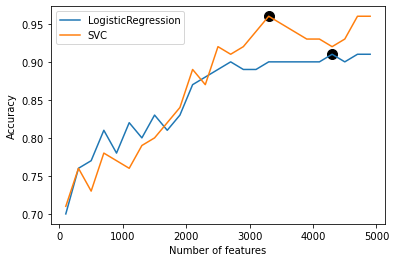

In [6]:
# Create list of classifiers
classifiers = [
    make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000)),
    make_pipeline(MinMaxScaler(), SVC(kernel='linear'))
]

# Drop zero variance features
selector = VarianceThreshold(threshold=0)
X_var = selector.fit_transform(X)

# Define range of K values to test
k_values = range(100, 5000, 200)

# Run cross-validation for each classifier and K value
accuracy = {'LogisticRegression': [], 'SVC': []}
for k in tqdm(k_values, desc='K values'):
    selector = SelectKBest(f_classif, k=k)
    X_new = selector.fit_transform(X_var, y)

    for clf in classifiers:
        scores  = cross_validate(
            clf, X_new, y, cv=5, scoring=['accuracy'], n_jobs=-1
        )
        accuracy[clf.steps[-1][1].__class__.__name__].append(
            scores['test_accuracy'].mean()
        )

# Plot the results
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_values, accuracy['LogisticRegression'], label='LogisticRegression')
ax.plot(k_values, accuracy['SVC'], label='SVC')
ax.set_xlabel('Number of features')
ax.set_ylabel('Accuracy')
ax.legend()

## Highlight the best K value for each classifier
best_k = {
    'LogisticRegression': k_values[accuracy['LogisticRegression'].index(max(accuracy['LogisticRegression']))],
    'SVC': k_values[accuracy['SVC'].index(max(accuracy['SVC']))]
}
ax.scatter(best_k['LogisticRegression'], max(accuracy['LogisticRegression']), color='k', s=100)
ax.scatter(best_k['SVC'], max(accuracy['SVC']), color='k', s=100);

> Based on the figure above, the best model for this task is a Support
> Vector Machine Classifier using the best 3300 features (as selected by
> the ANOVA F-value).

> ### Build the Final Model

In [19]:
# Drop zero variance features
selector = VarianceThreshold(threshold=0)
X_var = selector.fit_transform(X)

# Select K best features
selector = SelectKBest(f_classif, k=3300)
X_sel = selector.fit_transform(X_var, y)
I = selector.get_support(indices=True)

# Fit the SVC classifier
clf = make_pipeline(MinMaxScaler(), SVC(kernel='linear'))
clf.fit(X_sel, y);

> ### Make Predictions on the Grading Dataset

In [20]:
# Extract data for grading from the `grading` dataframe
X_grading = grading.values

# Select the K best features
X_grading_sel = X_grading[:, I]

# Predict the classes
y_grading = clf.predict(X_grading_sel)

### Save your predictions for the "grading" data to grading_predictions.txt.
Export your predictions for the grading samples to 'grading_predictions.txt'. The file needs to be a single column text file, with the first row containing 'class' and each of the additional rows containing your predicted class label for the grading samples. To create the grading_predictions.txt file, you may use numpy.savetext() or pandas.DataFrame.to_csv() functions (or any alternative method/function).


You must have grading_predictions.txt file available in your dropbox, as
well as upload the same file on Blackboard, for it to be considered for
grading.

In [10]:
# Save the predictions
with open('./grading_predictions.txt', 'w') as f:
    f.write('class\n')

    for y in y_grading:
        f.write(f'{y}\n')